# CEWA 568 Snow Hydrology - Spring 2023
## Homework 7: What Makes Snow Melt?

Daniel Hogan

---

In [1]:
import os
import urllib
from urllib.error import URLError
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

#import metpy
#from metpy.units import units
#import pint_xarray

import matplotlib.pyplot as plt

### Pull in the data and shift to local time

In [2]:
sos_dataset_60min = xr.open_dataset('./sos_EB_1Apr_15May2023.nc')
sos_dataset_60min = sos_dataset_60min.shift(time=-7)

### Plot timeseries of SWE, snow temperatures, soil temperatures, soil moisture, and 2m temperature

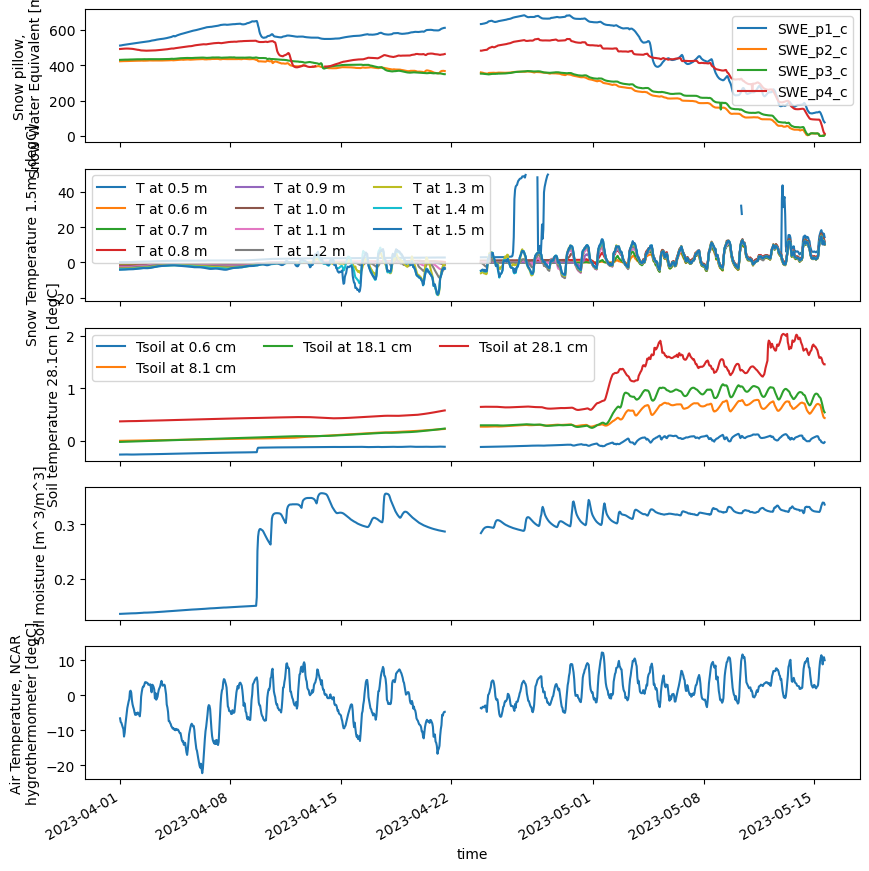

In [4]:
fig, axes = plt.subplots(5, 1, figsize=(10,10), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#sos_dataset_60min['Tsnow_0_4m_d'].plot(ax=axes[1], label='T at 0.4 m')
sos_dataset_60min['Tsnow_0_5m_d'].plot(ax=axes[1], label='T at 0.5 m')
sos_dataset_60min['Tsnow_0_6m_d'].plot(ax=axes[1], label='T at 0.6 m')
sos_dataset_60min['Tsnow_0_7m_d'].plot(ax=axes[1], label='T at 0.7 m')
sos_dataset_60min['Tsnow_0_8m_d'].plot(ax=axes[1], label='T at 0.8 m')
sos_dataset_60min['Tsnow_0_9m_d'].plot(ax=axes[1], label='T at 0.9 m')
sos_dataset_60min['Tsnow_1_0m_d'].plot(ax=axes[1], label='T at 1.0 m')
sos_dataset_60min['Tsnow_1_1m_d'].plot(ax=axes[1], label='T at 1.1 m')
sos_dataset_60min['Tsnow_1_2m_d'].plot(ax=axes[1], label='T at 1.2 m')
sos_dataset_60min['Tsnow_1_3m_d'].plot(ax=axes[1], label='T at 1.3 m')
sos_dataset_60min['Tsnow_1_4m_d'].plot(ax=axes[1], label='T at 1.4 m')
sos_dataset_60min['Tsnow_1_5m_d'].plot(ax=axes[1], label='T at 1.5 m')

sos_dataset_60min['Tsoil_0_6cm_d'].plot(ax=axes[2], label='Tsoil at 0.6 cm')
#sos_dataset_60min['Tsoil_1_9cm_d'].plot(ax=axes[2], label='Tsoil at 1.9 cm')
#sos_dataset_60min['Tsoil_3_1cm_d'].plot(ax=axes[2], label='Tsoil at 3.1 cm')
#sos_dataset_60min['Tsoil_4_4cm_d'].plot(ax=axes[2], label='Tsoil at 4.4 cm')
sos_dataset_60min['Tsoil_8_1cm_d'].plot(ax=axes[2], label='Tsoil at 8.1 cm')
#sos_dataset_60min['Tsoil_9_4cm_d'].plot(ax=axes[2], label='Tsoil at 9.4 cm')
#sos_dataset_60min['Tsoil_10_6cm_d'].plot(ax=axes[2], label='Tsoil at 10.6 cm')
#sos_dataset_60min['Tsoil_11_9cm_d'].plot(ax=axes[2], label='Tsoil at 11.9 cm')
sos_dataset_60min['Tsoil_18_1cm_d'].plot(ax=axes[2], label='Tsoil at 18.1 cm')
#sos_dataset_60min['Tsoil_19_4cm_d'].plot(ax=axes[2], label='Tsoil at 19.4 cm')
#sos_dataset_60min['Tsoil_20_6cm_d'].plot(ax=axes[2], label='Tsoil at 20.6 cm')
#sos_dataset_60min['Tsoil_21_9cm_d'].plot(ax=axes[2], label='Tsoil at 21.9 cm')
sos_dataset_60min['Tsoil_28_1cm_d'].plot(ax=axes[2], label='Tsoil at 28.1 cm')
#sos_dataset_60min['Tsoil_29_4cm_d'].plot(ax=axes[2], label='Tsoil at 29.4 cm')
#sos_dataset_60min['Tsoil_30_6cm_d'].plot(ax=axes[2], label='Tsoil at 30.6 cm')
#sos_dataset_60min['Tsoil_31_9cm_d'].plot(ax=axes[2], label='Tsoil at 31.9 cm')

sos_dataset_60min['Qsoil_d'].plot(ax=axes[3], label='soil moisture')

sos_dataset_60min['T_2m_c'].plot(ax=axes[4])

axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("")
axes[1].legend(ncols=3)
axes[2].legend(ncols=3)
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")
# axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

# Problem 1
Using the data collected, as presented in Lab 8-1, calculate (a) the total daily energy balance, (b) the total daily change in snow temperature, (c) the total daily vertical water vapor flux, and (d) the total daily snow melt for the period from April 1 to April 21, and then, separately from April 25 to May 10. Do our data suggest that the mass and energy budgets work? If not, what do you think are the primary sources of our errors? 

In [6]:
def apogee2temp(ds,tower):
    # hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = ds[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
    # unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861, 58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285, 287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932, 2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453, -214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657, -0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234, 0.10936][im]* 1e5
    # read data
    Vtherm = ds[f"Vtherm_{tower}"]
    Vpile = ds[f"Vpile_{tower}"]*1000
    # calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
    # finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    # TTc = TTc * units('celsius')
    return TTc

In [7]:
#SIGMA = 5.67e-8 # Stephan-Boltzmann Constant
#sos_ds = sos_ds.assign(LWout = (sos_ds.Rpile_out_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA),
#              LWin = (sos_ds.Rpile_in_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA))
# below is Eli's code and above is Danny's code -- At this point, I think we only need the below but saving the above just in case.

SB = 5.67e-08 # steven boltzman constant, W/m^2/degK^4
SNOW_EMMISIVITY = 0.98

sos_dataset_60min['LWin'] = (sos_dataset_60min['Rpile_in_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)
sos_dataset_60min['LWout'] = (sos_dataset_60min['Rpile_out_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)

sos_dataset_60min['Tsurf_rad_d'] = ((sos_dataset_60min['Rpile_out_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

# Surface Temperature
# calculate from apogees
sos_dataset_60min['Tsurf_c'] = (['time'], apogee2temp(sos_dataset_60min, 'c').values)
sos_dataset_60min['Tsurf_d'] = (['time'], apogee2temp(sos_dataset_60min, 'd').values)
sos_dataset_60min['Tsurf_ue'] = (['time'], apogee2temp(sos_dataset_60min, 'ue').values)
sos_dataset_60min['Tsurf_uw'] = (['time'], apogee2temp(sos_dataset_60min, 'uw').values)

In [8]:
# And calculate the density of air
Ra = 286.9
# above is specific gas constant for dry air in J/kg/K
sos_dataset_60min['ro'] = 100*sos_dataset_60min['P_10m_c']/(Ra * (sos_dataset_60min['T_10m_c']+273.15))

## Calculate the total energy balance each hour

The total energy balance at the snow suface is

$$
c_p^{SS} \frac{\delta T_{SS}}{\delta t} + \lambda \frac{\delta T_{S}}{\delta z} + E_{melt} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH + G 
$$

where the left hand side represents changes to the snowpack, through warming the surface temperature $c_p^{SS} \frac{\delta T_{SS}}{\delta t}$, conducting heat into lower layers of the snowpack $\lambda \frac{\delta T_{S}}{\delta z}$, or melting the snow $E_{melt}$.  

This is balanced by the heat exchange at the surface $LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH$ and the ground heat flux $G$.  

We need to be very careful with the signs and units of all of these terms, as we will see below.

## Calculate components and sums of surface fluxes

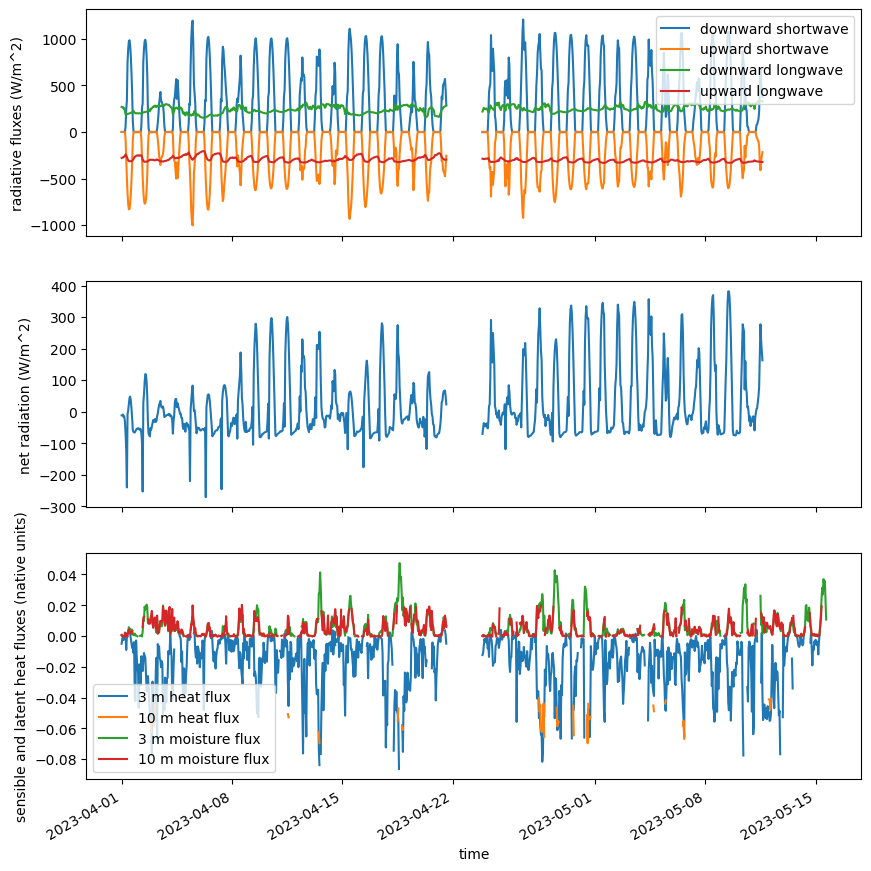

In [9]:
# import matplotlib.pyplot as plt
sos_dataset_60min['w_h2o__3m_c'] = sos_dataset_60min['w_h2o__3m_c'].where(sos_dataset_60min['w_h2o__3m_c']>np.nanpercentile(sos_dataset_60min['w_h2o__3m_c'].values,2))
sos_dataset_60min['w_h2o__10m_c'] = sos_dataset_60min['w_h2o__10m_c'].where((sos_dataset_60min['w_h2o__10m_c']>np.nanpercentile(sos_dataset_60min['w_h2o__10m_c'].values,2))
                                                                            & (sos_dataset_60min['w_h2o__10m_c']<np.nanpercentile(sos_dataset_60min['w_h2o__10m_c'].values,98)))

# sos_dataset_60min['w_tc__3m_c'] = sos_dataset_60min['w_tc__3m_c'].where(sos_dataset_60min['w_tc__3m_c']<np.nanpercentile(sos_dataset_60min['w_tc__3m_c'].values,98))
# sos_dataset_60min['w_tc__10m_c'] = sos_dataset_60min['w_tc__10m_c'].where(sos_dataset_60min['w_tc__10m_c']<np.nanpercentile(sos_dataset_60min['w_tc__10m_c'].values,98))

fig, axes = plt.subplots(3,1, figsize=(10,10), sharex=True)

sos_dataset_60min['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')
(-1 * sos_dataset_60min['Rsw_out_9m_d']).plot(ax=axes[0], label='upward shortwave')
sos_dataset_60min['LWin'].plot(ax=axes[0], label='downward longwave')
(-1 * sos_dataset_60min['LWout']).plot(ax=axes[0], label='upward longwave')

(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']).plot(ax=axes[1], label='net rad')

# then, let's look at the sensible heat flux at two heights
sos_dataset_60min['w_tc__3m_c'].plot(ax=axes[2], label='3 m heat flux')
sos_dataset_60min['w_tc__10m_c'].plot(ax=axes[2], label='10 m heat flux')

# and let's look at the latent heat flux at two heights
sos_dataset_60min['w_h2o__3m_c'].plot(ax=axes[2], label='3 m moisture flux')
sos_dataset_60min['w_h2o__10m_c'].plot(ax=axes[2], label='10 m moisture flux')


axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("radiative fluxes (W/m^2)")
axes[1].set_ylabel("net radiation (W/m^2)")
axes[2].legend()
axes[2].set_ylabel("sensible and latent heat fluxes (native units)")
#axes[3].set_ylabel("Richardson Number")
#axes[3].set_ylim(-0.5, 0.5)

plt.show()

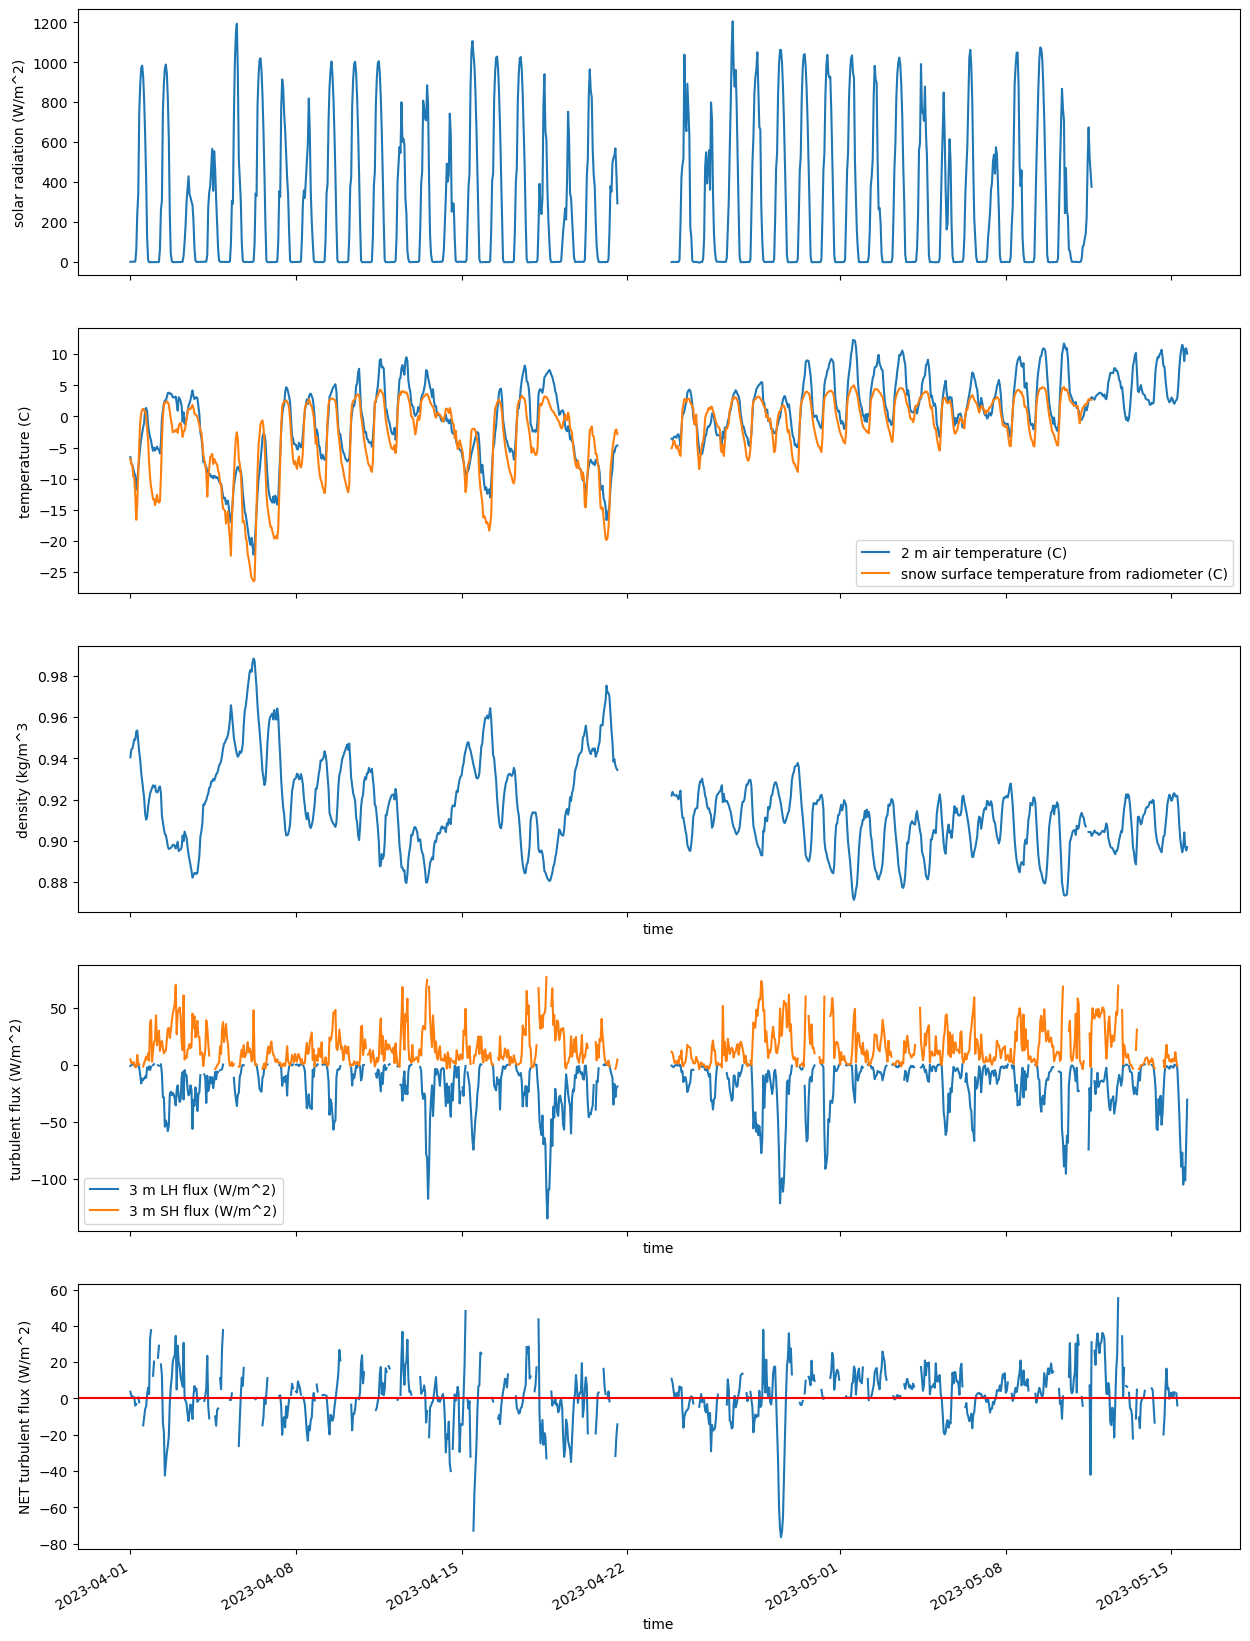

In [10]:
Lh_sub = 2835
# above we define latent heat of sublimation in J/g

cpair = 1005.7
# above is specific heat at constant pressure for dry air in J/kg/K as reported by the Glossary of Meteorology
# density of air was calculated above

# Let's make some simpler plots for the same time period to help us with interpretation.
fig, axes = plt.subplots(5,1, figsize=(15,20), sharex=True)

# I like to plot shortwave radiation to understand the timing of sunrise and relative cloudiness
sos_dataset_60min['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')

# then, I like to see the actual temperatures, before the gradient is calculated
sos_dataset_60min['T_2m_c'].plot(ax=axes[1], label='2 m air temperature (C)')
sos_dataset_60min['Tsurf_rad_d'].plot(ax=axes[1], label='snow surface temperature from radiometer (C)')

# and check that denisty i okay
sos_dataset_60min['ro'].plot(ax=axes[2], label='2 m air temperature (C)')

# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[3], label='3 m LH flux (W/m^2)')
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c']).plot(ax=axes[3], label='3 m SH flux (W/m^2)')

# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[4], label='sum turbulent flux (W/m^2)')

plt.axhline(y = 0, color = 'r', linestyle = '-')


axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].legend()
axes[3].legend()
axes[0].set_ylabel("solar radiation (W/m^2)")
axes[1].set_ylabel("temperature (C)")
axes[2].set_ylabel("density (kg/m^3")
axes[3].set_ylabel("turbulent flux (W/m^2)")
axes[4].set_ylabel("NET turbulent flux (W/m^2)")
#axes[3].set_ylim(-0.2, 0.2)

plt.show()

The plot above shows the energy balance and turbulent fluxes over the period from April 1 to May 15. After a brief cold spell in mid-April, we see a return to above 0 temperatures during the day. Net turbulent fluxes over the final period in May was primarily positive, meaning heat was generally going into the snowpack (powering melt processes).

Text(0, 0.5, 'Cumulative sum Combined flux (W/m^2*hr)')

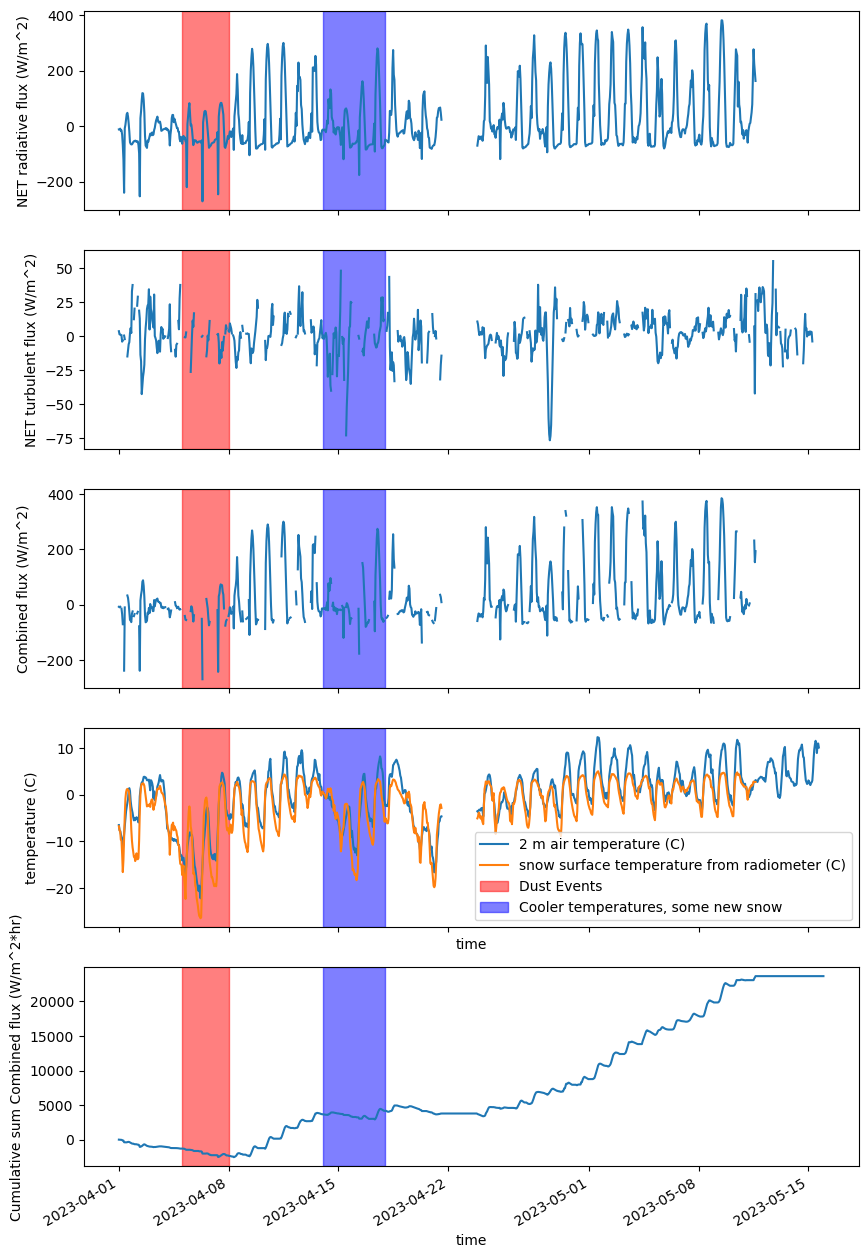

In [19]:
fig, axes = plt.subplots(5,1, figsize=(10,15), sharex=True)
(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']).plot(ax=axes[0], label='net rad')
# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[1], label='sum turbulent flux (W/m^2)')

#and add them all together
(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[2], label='net energy')

#plt.axhline(y = 0, color = 'r', linestyle = '-')

# and compare with surface temperature
# then, I like to see the actual temperatures, before the gradient is calculated
sos_dataset_60min['T_2m_c'].plot(ax=axes[3], label='2 m air temperature (C)')
sos_dataset_60min['Tsurf_rad_d'].plot(ax=axes[3], label='snow surface temperature from radiometer (C)')

#and look at the cumulative energy sum
(np.cumsum(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])).plot(ax=axes[4], label='net energy')

for ax in axes:
    ax.axvspan(dt.date(2023,4,5),dt.date(2023,4,8),
               label='Dust Events',
               alpha=0.5,
               color='red')
    ax.axvspan(dt.date(2023,4,14),dt.date(2023,4,18),
               label='Cooler temperatures, some new snow',
               alpha=0.5,
               color='blue')
    


axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
#axes[1].legend()
axes[3].legend()
axes[0].set_ylabel("NET radiative flux (W/m^2)")
axes[1].set_ylabel("NET turbulent flux (W/m^2)")
axes[2].set_ylabel("Combined flux (W/m^2)")
axes[3].set_ylabel("temperature (C)")
axes[4].set_ylabel("Cumulative sum Combined flux (W/m^2*hr)")

It is interesting to note te continued negative combined flux even after the melt period. I think clouds may have played a big role here is modulating the energy balance on this day. The cold period in mid-April also shows a return to negative cumulative combined fluxes.

### 1.A Total daily energy balance
Here we see the daily snow surface energy balance $R_{net} - H_s - H_l$  (there are two periods with 0s in the beginning and on April 22 and April 23). We see lots of energy over each day accrued after the cold period in early April. We see daily net energy really start to increase towards May. This gives use the right hand side of the energy balance equation 
$$
LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH 
$$

To me, these values seem really high, but I think the sunny, longer spring days really do just add a significant amount of energy. Integrated over the day, we see that the surface lots of energy is being pumped into the surface, likely encouraging melt on a large scale, especially in the later of the two periods.

Text(0.5, 1.0, 'Total Daily Energy Balance (April 25 - May 10)')

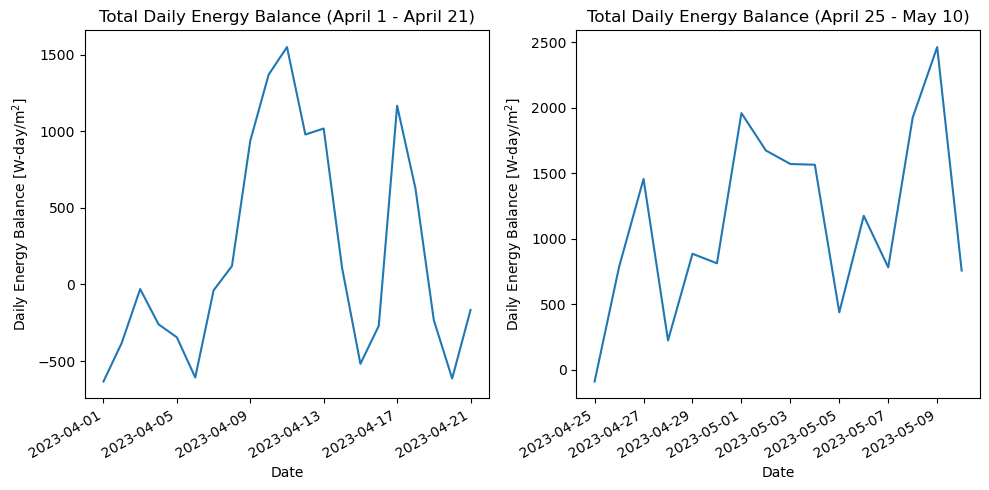

In [94]:
net_hourly = (sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout'] - cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])

fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)
net_hourly.sel(time=slice('2023-04-01','2023-04-21')).resample(time='1D').sum().plot(ax=axs[0])
axs[0].set_ylabel('Daily Energy Balance [W-day/m$^2$]')
axs[0].set_xlabel('Date')
axs[0].set_title('Total Daily Energy Balance (April 1 - April 21)')

net_hourly.sel(time=slice('2023-04-25','2023-05-10')).resample(time='1D').sum().plot(ax=axs[1])
axs[1].set_ylabel('Daily Energy Balance [W-day/m$^2$]')
axs[1].set_xlabel('Date')
axs[1].set_title('Total Daily Energy Balance (April 25 - May 10)')


### 1.B. Total Daily Temperature Change
I calculated this as the temperature change between the last and first temperature measurements over the day at each depth. I chose a representative depth of the 0.6 meter location as this was approximately in the center of the downwind snowpack from peak SWE. I would expect that before a location melts, the difference values would be essentially 0, meaning that all energy going into the snowpack is gone to melt the snow. Once snow melts we see a large increase in these differences. This plot shows that since the internal energy of the snowpack is not changing much, we do not need to strongly consider the first two terms of the surface energy balance if we are looking at order of magnitude signals. So our simplified equation now looks like this:
$$
E_{melt} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH
$$

Once the snowpack is ripe, all energy should be going to melting the snow, meaning the net energy going into the snowpack should balance with the energy needed to melt the snowpack.

In [57]:
tsnow_daily_diff_0_5m_d = sos_dataset_60min['Tsnow_0_5m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_5m_d'].resample(time='1D').first()
tsnow_daily_diff_0_6m_d = sos_dataset_60min['Tsnow_0_6m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_6m_d'].resample(time='1D').first()
tsnow_daily_diff_0_7m_d = sos_dataset_60min['Tsnow_0_7m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_7m_d'].resample(time='1D').first()
tsnow_daily_diff_0_8m_d = sos_dataset_60min['Tsnow_0_8m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_8m_d'].resample(time='1D').first()
tsnow_daily_diff_0_9m_d = sos_dataset_60min['Tsnow_0_9m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_0_9m_d'].resample(time='1D').first()
tsnow_daily_diff_1_0m_d = sos_dataset_60min['Tsnow_1_0m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_0m_d'].resample(time='1D').first()
tsnow_daily_diff_1_1m_d = sos_dataset_60min['Tsnow_1_1m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_1m_d'].resample(time='1D').first()
tsnow_daily_diff_1_2m_d = sos_dataset_60min['Tsnow_1_2m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_2m_d'].resample(time='1D').first()
tsnow_daily_diff_1_3m_d = sos_dataset_60min['Tsnow_1_3m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_3m_d'].resample(time='1D').first()
tsnow_daily_diff_1_4m_d = sos_dataset_60min['Tsnow_1_4m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_4m_d'].resample(time='1D').first()
tsnow_daily_diff_1_5m_d = sos_dataset_60min['Tsnow_1_5m_d'].resample(time='1D').last() - sos_dataset_60min['Tsnow_1_5m_d'].resample(time='1D').first()

Text(0.5, 1.0, 'Daily Net Temperature Difference (C) (April 25 - May 10)')

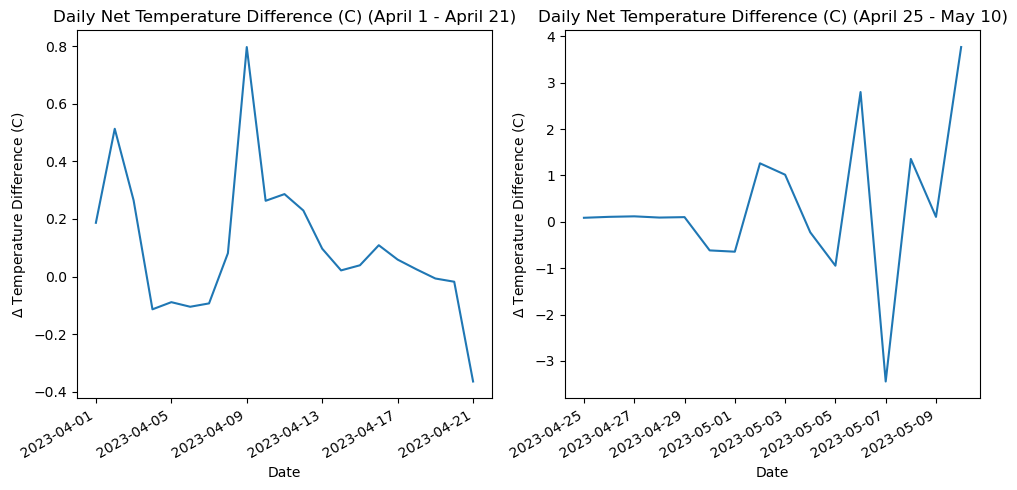

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)
tsnow_daily_diff_0_8m_d.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])
axs[0].set_ylabel('$\Delta$ Temperature Difference (C)')
axs[0].set_xlabel('Date')
axs[0].set_title('Daily Net Temperature Difference (C) (April 1 - April 21)')

tsnow_daily_diff_0_8m_d.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1])
axs[1].set_ylabel('$\Delta$ Temperature Difference (C)')
axs[1].set_xlabel('Date')
axs[1].set_title('Daily Net Temperature Difference (C) (April 25 - May 10)')

We see that in the early period, our difference in snow temperature is close to zero likely meaning that the snowpack is ripe. This shifts to much larger values once we start melting out thermistors that were previously in the snowpack.

### Total Daily Water Vapor Flux
To give us an idea of sublimation rates over this period, I calculated this by taking the 3m sonic water vapor flux and converting it to a daily depth by taking the hourly mean (in $m/s * g/m^2$) and converting this to $mm/day$ by multiplying by the number of seconds in a day, dividing by the density of water, and converting meters to mm. The total sublimation/melt+evaporation is around 1-inch (20 mm).


Text(0.5, 1.0, 'Daily Sublimation rate(April 25 - May 10)\nSum total = 8.0 mm')

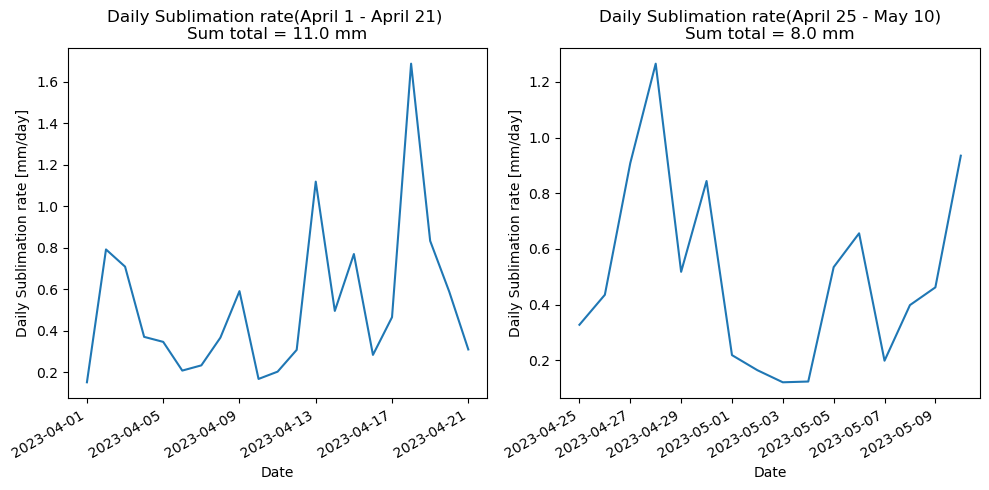

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)
(sos_dataset_60min['w_h2o__3m_c'].sel(time=slice('2023-04-01','2023-04-21')).resample(time='1D').mean()*24*3600/1e3).plot(ax=axs[0])
axs[0].set_ylabel('Daily Sublimation rate [mm/day]')
axs[0].set_xlabel('Date')
sum_total_p1 = (sos_dataset_60min['w_h2o__3m_c'].sel(time=slice('2023-04-01','2023-04-21')).resample(time='1D').mean()*24*3600/1e3).values.sum()
axs[0].set_title(f'Daily Sublimation rate(April 1 - April 21) \nSum total = {round(sum_total_p1,2)} mm')

(sos_dataset_60min['w_h2o__3m_c'].sel(time=slice('2023-04-25','2023-05-10')).resample(time='1D').mean()*24*3600/1e3).plot(ax=axs[1])
axs[1].set_ylabel('Daily Sublimation rate [mm/day]')
axs[1].set_xlabel('Date')
sum_total_p2 = (sos_dataset_60min['w_h2o__3m_c'].sel(time=slice('2023-04-25','2023-05-10')).resample(time='1D').mean()*24*3600/1e3).values.sum()
axs[1].set_title(f'Daily Sublimation rate(April 25 - May 10)\nSum total = {np.round(sum_total_p2,0)} mm')

### 1.D. Daily Snowmelt

Here I will take the difference between the first and the last measurement for each day to get millimeters of melt per day and then convert this into an amount of energy that was needed to melt that snow in $W/m^2$

In [20]:
dSWE_1 = sos_dataset_60min['SWE_p1_c'].resample(time='1D').mean().diff(dim='time')
dSWE_2 = sos_dataset_60min['SWE_p2_c'].resample(time='1D').mean().diff(dim='time')
dSWE_3 = sos_dataset_60min['SWE_p3_c'].resample(time='1D').mean().diff(dim='time')
dSWE_4 = sos_dataset_60min['SWE_p4_c'].resample(time='1D').mean().diff(dim='time')

Text(0.5, 1.0, 'Daily Snowmelt/Gain (negative is melt) (April 25 - May 10)')

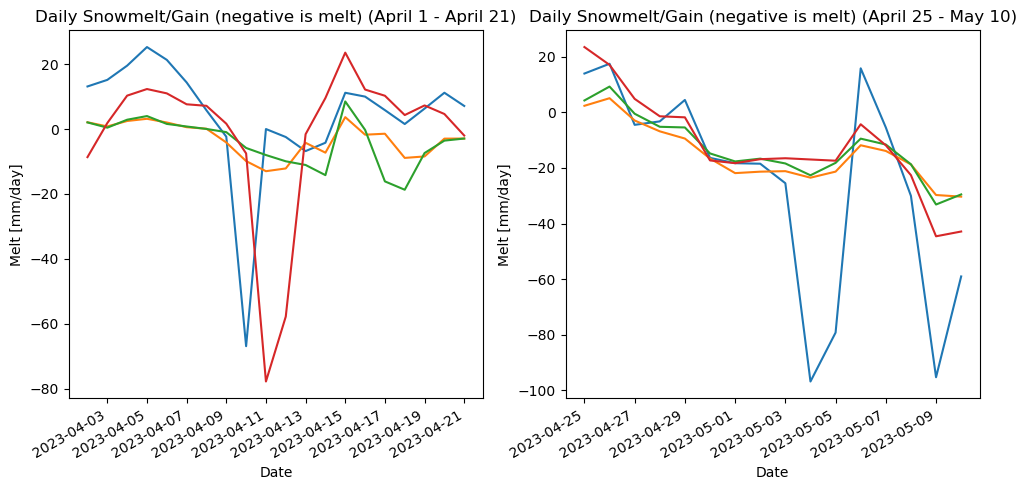

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

dSWE_1.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])
dSWE_2.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])
dSWE_3.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])
dSWE_4.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])

axs[0].set_ylabel('Melt [mm/day]')
axs[0].set_xlabel('Date')
axs[0].set_title('Daily Snowmelt/Gain (negative is melt) (April 1 - April 21)')

dSWE_1.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1])
dSWE_2.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1])
dSWE_3.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1])
dSWE_4.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1])

axs[1].set_ylabel('Melt [mm/day]')
axs[1].set_xlabel('Date')
axs[1].set_title('Daily Snowmelt/Gain (negative is melt) (April 25 - May 10)')

Now lets convert this melt into an amount of energy by multiplying our amount of snow that melted and converting it to watts per meter square using the latent heat of melting (334 J/g)

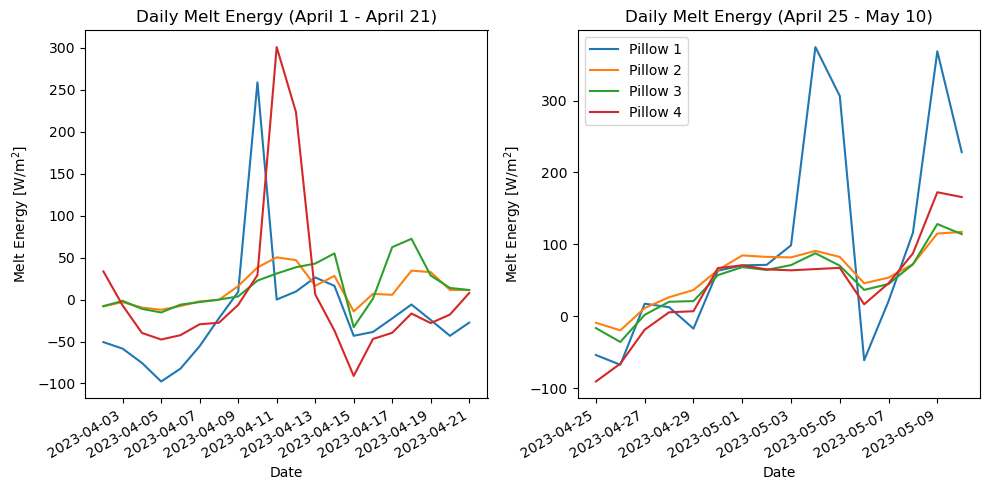

In [88]:
melt_energy_p1 = -dSWE_1 * 334 * 1000 / 3600 /24
melt_energy_p2 = -dSWE_2 * 334 * 1000 / 3600 /24
melt_energy_p3 = -dSWE_3 * 334 * 1000 / 3600 /24
melt_energy_p4 = -dSWE_4 * 334 * 1000 / 3600 /24


fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

melt_energy_p1.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])
melt_energy_p2.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])
melt_energy_p3.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])
melt_energy_p4.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])

axs[0].set_ylabel('Melt Energy [W/m$^2$]')
axs[0].set_xlabel('Date')
axs[0].set_title('Daily Melt Energy (April 1 - April 21)')

melt_energy_p1.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1], label='Pillow 1')
melt_energy_p2.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1], label='Pillow 2')
melt_energy_p3.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1], label='Pillow 3')
melt_energy_p4.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1], label='Pillow 4')

axs[1].set_ylabel('Melt Energy [W/m$^2$]')
axs[1].set_xlabel('Date')
axs[1].set_title('Daily Melt Energy (April 25 - May 10)')
axs[1].legend()

Interesting... either I missed a unit conversion somewhere or my energy balance is of by about an order of magnitude. Let's first plot this melt energy against our net energy and see if there is a relationship between signals. To do this we'll take the mean across our pillows. I will caveat this with the fact that our pillows show a significant amount of variability in the melt rates, but we are trying to get a sense of what the values may have been across the site as a whole, so I will include all locations.

Between the two periods, we see a more monotonically increasing melt signal during the later period, likely due to the lack of cold periods, increasing temperatures and solar energy availability.

Text(0.5, 1.0, 'Mean daily melt energy across pillows (April 25 - May 10)')

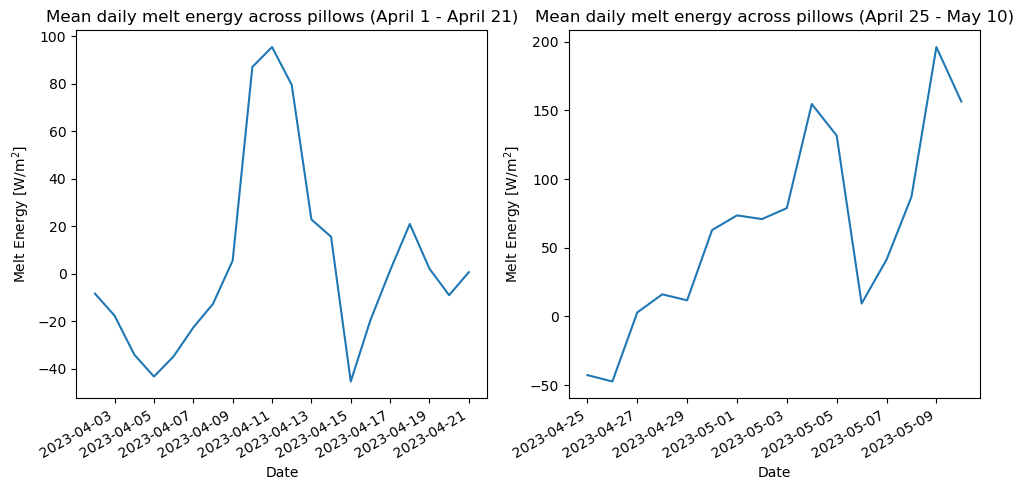

In [92]:
mean_melt_energy = (melt_energy_p1  + melt_energy_p2 + melt_energy_p3 + melt_energy_p4) / 4

fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

mean_melt_energy.sel(time=slice('2023-04-01','2023-04-21')).plot(ax=axs[0])

axs[0].set_ylabel('Melt Energy [W/m$^2$]')
axs[0].set_xlabel('Date')
axs[0].set_title('Mean daily melt energy across pillows (April 1 - April 21)')

mean_melt_energy.sel(time=slice('2023-04-25','2023-05-10')).plot(ax=axs[1])

axs[1].set_ylabel('Melt Energy [W/m$^2$]')
axs[1].set_xlabel('Date')
axs[1].set_title('Mean daily melt energy across pillows (April 25 - May 10)')

Now I plot our net energy from melt against our net energy from longwave, shortwave and turbulent fluxes. Squinting at this plot, I can see a generally increasing relationship between the two, but there is an order of magnitude difference between the values. 

I'm not sure where this difference stems from exactly, but it does not appear to show that we can close the energy balance. I think that I could have missed a unit somewhere or we could have substantial errors in the assumption that our snowpack is not changing temperature with time, especially at the surface where we know it gets substantially colder overnight. 

I do want to highlight that for the net energy calculation, I took the sum of hourly net values over the day in order to capture the net total sum of energy, but I'm unsure if this was correct. I think it makes sense to calculate the integrated sum of energy over the day since I'm comparing it to the energy needed to melt snow for an entire day (this way the units make sense), but that would make an order of magnitude difference.

Additionally, the snow melt rates over the snow pillows that are used to calculate the energy needed to melt snow could be underestimating the amount of melt, although melt rates do seem very high for some locations, so I'm unsure if this is actually the case.

(-600.0, 2500.0)

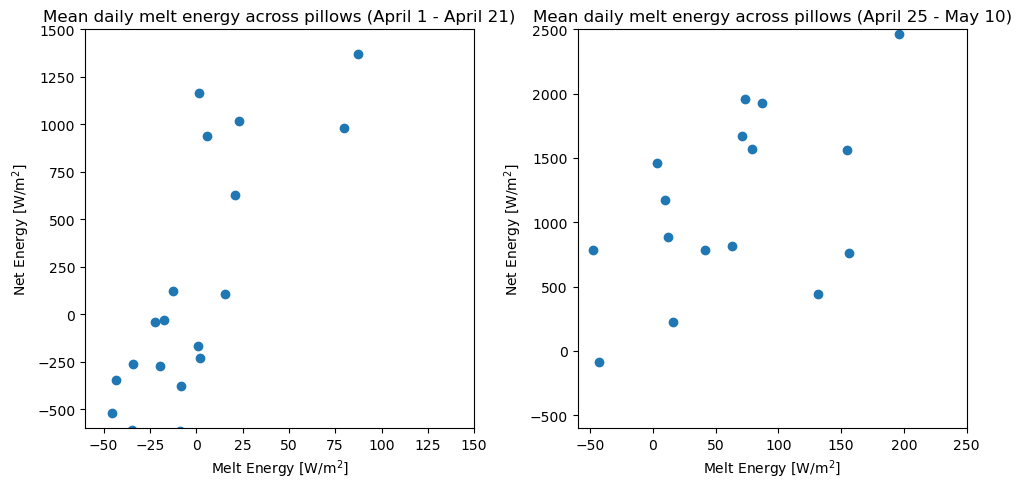

In [98]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

axs[0].scatter(mean_melt_energy.sel(time=slice('2023-04-01','2023-04-21')),
            net_hourly.resample(time='1D').sum().sel(time=slice('2023-04-02','2023-04-21')))

axs[0].set_xlabel('Melt Energy [W/m$^2$]')
axs[0].set_ylabel('Net Energy [W/m$^2$]')
axs[0].set_title('Mean daily melt vs net energy (April 1 - April 21)')
axs[0].set_xlim(-60,150)
axs[0].set_ylim(-600,1500)

axs[1].scatter(mean_melt_energy.sel(time=slice('2023-04-25','2023-05-10')),
            net_hourly.resample(time='1D').sum().sel(time=slice('2023-04-25','2023-05-10')))

axs[1].set_xlabel('Melt Energy [W/m$^2$]')
axs[1].set_ylabel('Net Energy [W/m$^2$]')
axs[1].set_title('Mean daily melt vs net energy (April 25 - May 10)')
axs[1].set_xlim(-60,250)
axs[1].set_ylim(-600,2500)

# Problem 2:

I liked the modules and the information covered but I think thr ordering could be improved to allow for more contunity and building a stronger base for different topics. I like the idea of following the snowpack (as in ending with calculating melt and looking at melt processes), but I think the order could go something like this:

Weeks 1-4: Fundamentals of mountain meteorology, surface energy balance, and snow physics
- Week 1 & 2: Introduction to jupyterlab and mountain meteorology background: how do we get snow and how terrain influences snowfall/patterns? Focus on where snow comes from.
- Week 3: What is snow: Phases and Properties of matter. Focus on how snow forms, falls, and accumulates
- Week 4: The snow surface energy balance

Weeks 5-7: Fundamentals of snow on the ground: measurments, observations
- Week 5: How does a snowpack change? Focus on field outing, snowpits, observations properties of snow over time.
- Week 6: Temperatures above, below, and within the snow
- Week 7: Turbulent Transfer above the snow

Weeks 8 & 9: Fundamentals of the snow mass balance and melt processes
- Week 8: Mass & Energy balance: blowing snow, wind, etc
- Week 9: What makes snow melt


This organizational setup for the structure of the course would allow us to follow the trajectory of snow over the year, but also provide more continuity and building between topics. 
I think 2 weeks could be spent on either mountain meteorology, the surface energy balance, or turbulence over snow. But I think the most useful would likely be more background in meteorology or the energy balance.

I think if we setup all the data everyone needed before hand, that would be really helpful to get people going. I imagine there were some struggles pulling data to get plots together. I also think if we had a general timeline of events over the winter it could help orient people when looking for interesting periods to study. 